# Optimization of Periodic Plane Colorings via Simulated Annealing
## Haydn Gwyn

In [1]:
from random import random, randint
from math import sqrt, ceil, exp
from PIL import Image

## Representing colorings
The class below encapsulates the data associated with a coloring of a
rectangular grid of pixels. The parameters `rows` and `cols` identify
the number of rows and columns of pixels in the grid (we are dealing
with a matrix of pixels, after all), and the `side_height` and `side_width`
are the dimensions of the grid when embedded in the plane. The `colors`
parameter determines the number of colors, and the `wrapping` parameter
affects how we calculate the badness of the coloring. In particular, when
wrapping is off, we don't consider edges that wrap around the border of
the rectuangular region in calculating the badness of a particular pixel.

In [2]:
class Coloring(object):
    """
    A coloring of a grid of fixed height and width, where colors are
    assigned to "pixels" (which are actually small rectangles). The number
    of pixels in the grid and the number of colors are fixed at instantiation.
    """
    RENDER_CUTOFF = 500 # the minimum size, in pixels, of the rendered coloring
    COLORS = [(0, 51, 102),  #yale blue
              (218, 165, 32),#california gold
              (255, 0, 0),   #red
              (0, 255, 0),   #green
              (0, 0, 255),   #blue
              (255, 255, 0), #yellow
              (255, 0, 255), #pink
              (0, 255, 255), #cyan
              (0, 0, 0)]     #black
    
    def __init__(self, rows, cols, side_height, side_width, colors, wrapping=True):
        """Constructor for Coloring."""
        self.rows = rows
        self.cols = cols
        self.side_height = side_height
        self.side_width = side_width
        self.colors = colors
        self.wrapping = wrapping
        
        #set the dimensions of the Coloring's grid
        self.grid = [[0 for _ in range(cols)] for __ in range(rows)]
        #note that "pixels" in this sense are not necessarily squares
        self.pw = side_width / self.cols  # the width of a pixel
        self.ph = side_height / self.rows # the height of a pixel
        
        #helpful for rendering the coloring as an image
        self.render_scale = ceil(self.RENDER_CUTOFF / max(rows, cols))
        self.im = Image.new('RGB', (self.render_scale * cols, self.render_scale * rows))
    
    def initialize_constant(self, k=0):
        """Set the color of every pixel in the grid to the same value."""
        for i in range(self.rows):
            for j in range(self.cols):
                self.grid[i][j] = k
                
    def initialize_random(self):
        """For each pixel in the grid, randomly select a color to assign to it."""
        for i in range(self.rows):
            for j in range(self.cols):
                self.grid[i][j] = randint(0, self.colors-1)
    
    def random_neighbor(self, prob):
        """
        For each of the pixels in the grid, change the pixel's color with probability prob
        this method is not used in the simulated annealing procedure below for time reasons,
        but it is theoretically still a viable neighbor function.
        """
        other = Coloring(self.rows, self.cols, self.side_height, self.side_width, self.colors, self.wrapping)
        for i in range(self.rows):
            for j in range(self.cols):
                other.grid[i][j] = self.grid[i][j]
                if random() < prob:
                    while self.grid[i][j] == other.grid[i][j]:
                        other.grid[i][j] = randint(0, self.colors-1)
        return other
    
    def pixel_badness(self, i, j):
        """
        For a particular pixel in the grid, calculate the proportion of pixels containing
        a point one unit from the given pixel that are the same color as the given pixel.
        """
        total = 0
        bad = 0
        for i2 in range(int(i - 1/self.ph) - 1, int(i + 1/self.ph) + 1):
            vdist_min = max((abs(i-i2)-1) * self.ph, 0)
            vdist_max = (abs(i-i2)+1) * self.ph
            
            if vdist_min > 1:
                continue
                
            #if i2 < 0 or i2 >= self.rows:
            #    i2 == i2 % self.rows
            #    j == self.cols - j - 1
            
            hdist_min = sqrt(max(1-vdist_max**2, 0))
            hdist_max = sqrt(max(1-vdist_min**2, 0))
            
            min_pixels = int(hdist_min / self.pw)
            max_pixels = ceil(hdist_max / self.pw)
            
            if self.wrapping:
                for k in range(j - max_pixels, j - min_pixels + 1):
                    total += 1
                    if self.grid[i2%self.rows][k%self.cols] == self.grid[i][j]:
                        bad += 1
                for k in range(j + min_pixels, j + max_pixels + 1):
                    total += 1
                    if self.grid[i2%self.rows][k%self.cols] == self.grid[i][j]:
                        bad += 1
            else:
                if i2 < 0 or i2 >= self.rows:
                    continue
                for k in range(max(j - max_pixels, 0), max(j - min_pixels + 1, 0)):
                    total += 1
                    if self.grid[i2][k] == self.grid[i][j]:
                        bad += 1
                for k in range(min(j + min_pixels, self.cols-1), min(j + max_pixels + 1, self.cols-1)):
                    total += 1
                    if self.grid[i2][k] == self.grid[i][j]:
                        bad += 1
        return bad/total
    
    def badness(self):
        """Calculate the badness of the coloring by averaging the badness over all pixels."""
        tot = 0
        for i in range(self.rows):
            for j in range(self.cols):
                tot += self.pixel_badness(i,j)
        return tot / (self.rows*self.cols)
    
    def render(self):
        """Render the coloring as an image."""
        px = self.im.load()
        for i in range(self.im.size[0]):
            for j in range(self.im.size[1]):
                px[i,j] = self.COLORS[self.grid[j//self.render_scale][i//self.render_scale]]
    
    def generate_badness_map(self):
        im = Image.new('RGB', (self.render_scale * self.cols, self.render_scale * self.rows))
        px = im.load()
        badness_arr = [[self.pixel_badness(i, j) for j in range(self.cols)] for i in range(self.rows)]
        max_pixel_badness = max([max(row) for row in badness_arr])
        for i in range(im.size[0]):
            for j in range(im.size[1]):
                px[i,j] = (int(255*badness_arr[j//self.render_scale][i//self.render_scale]/max_pixel_badness), 0, int(255*(1-badness_arr[j//self.render_scale][i//self.render_scale]/max_pixel_badness)))
        return im
    

## Simulated annealing process
With our representation of colorings complete, we can now implement a simulated annealing procedure
to run on them. The simulated annealing process proceeds like so:

 1. Let the current state be called $S$.
 2. Generate a _neighbor_ $S'$ of $S$ by performing some modification.  
  - In this case, that modification is randomly selecting a pixel and randomly modifying its color.
 3. Calculate the _energy function_ $E$ for each of $S$ and $S'$. That is, calculate $E(S)$ and $E(S')$.  
  - Our energy function is the probability that two randomly selected points one unit apart will have the same color.
  - We can greatly speed up this calculation by assuming that one of the two points is our randomly chosen pixel. We justify this below.
 4. Determine the probability with which to switch from $S$ to $S'$. This probability will take the form
 
 $$P = \exp((E(S) - E(S')/kT)$$
 
    where $k$ is a constant and $T$ is a _temperature function_ that decreases with time.
  - We could express $E(S')$ and $E(S)$ as linear combinations of indicator functions for the monochromaticity of each unit-distance pair of pixels. Subtracting these would cause all pairs except for those involving the modified pixel to cancel out, which justifies the earlier simplification.
  - We opt for an exponentially decaying temperature function in the code below.
  - Note that if $E(S') < E(S)$, then $P > 1$. Since $P$ is a probability, however, we cap it at $1$.
 5. Switch from $S$ to $S'$ with probability $P$. 
  - If $E(S') < E(S)$, this is guaranteed to occur. Otherwise, there may still be a nonzero probability of switching from $S$ to $S'$ even though $S'$ is "worse"
 6. Repeat this process many times as the temperature (ideally) approaches 0.

In [3]:
def anneal_step(coloring, curr_temp):
    """
    Perform a single iteration of the simulated annealing process. This entails
     - generating a neighboring coloring by modifying the color of a single pixel
     - calculating the badness of the modified pixel with the old and the new color
     - calculating the probability with which the color of the pixel should be changed
     - changing the pixel with the aforementioned probability
    
    Returns True if the color of the pixel was changed, else False
    """
    #randomly choose a pixel 
    i = randint(0, coloring.rows - 1)
    j = randint(0, coloring.cols - 1)
    
    #generate the new candidate color for the pixel
    new_color = old_color = coloring.grid[i][j]
    while new_color == old_color:
        new_color = randint(0, coloring.colors-1)
        
    #calculate old and new badness values
    old_badness = coloring.pixel_badness(i, j)
    coloring.grid[i][j] = new_color
    new_badness = coloring.pixel_badness(i, j)
    
    #calculate the change probability and change accordingly
    try:
        switch_prob = 1 - exp((new_badness - old_badness) / 2 / curr_temp)
    except OverflowError:
        switch_prob = 0
    if random() > switch_prob:
        coloring.grid[i][j] = old_color
        return False
    return True

In [4]:
def anneal(coloring, scale_down_factor=0.999, num_iters=None, num_jumps=None, verbose=False):
    """
    Carry out the entirety of the simulated annealing process. 
    
    Notes:
     - we've opted for an exponentially decaying temperature function
     - the default limit on the number of iterations is inversely proportional
       to one minus the factor by which the temperature decays in each iteration
    """
    if not num_iters:
        num_iters = int(coloring.rows * coloring.cols * 0.01 / (1 - scale_down_factor))
    if not num_jumps:
        num_jumps = num_iters / 10
    jumps = 0
    
    #one should never need to modify this starting value; instead, modify the constant
    #factor in the switch_prob calculation within anneal_step
    temperature = 1
    for i in range(num_iters):
        if verbose and i%100 == 0:
            print(coloring.badness())
        jumps += anneal_step(coloring, temperature)
        if jumps >= num_jumps:
            break
        temperature *= scale_down_factor

## Some examples

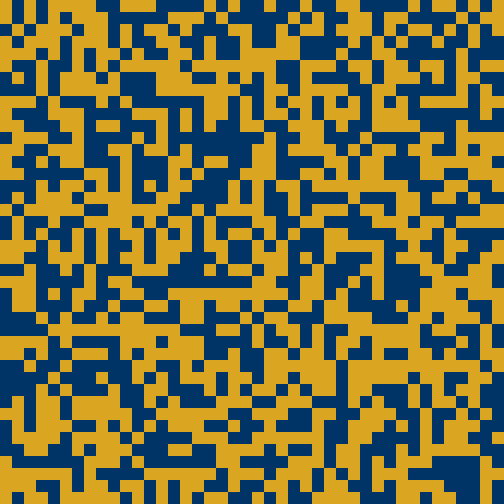

In [5]:
"""
We have an 80 x 80 grid of pixels that we embed in the plane as
a 4.5 x 4.5 unit square. We use seven colors here and default to
using wrapping.
"""
c = Coloring(42, 42, 0.2, 0.2, 2)
c.initialize_random()
c.render()
c.im

In [6]:
anneal(c, verbose=False)

0.44649066780214275


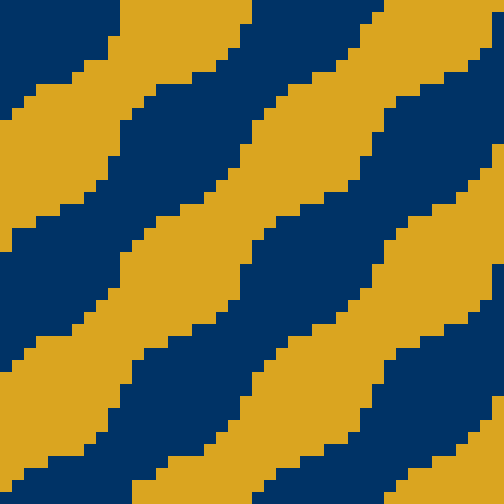

In [34]:
c.render()
print(c.badness())
c.im

What we start to see forming is a _hexagonal tiling_ of the plane. Indeed, Isbell offered such a tiling in 1960 as proof that the chromatic number of the plane is at most 7, and this remains the best upper bound that we have. In the output from the annealing program above, we can see that the badness of the coloring approaches 0 as we continue iterating, and in fact, the consequence of this hexagonal tiling being a _valid coloring_ (one which lacks monochromatic unit-distance pairs) is that we can actually reach a badness value of 0 with 7 colors. We may not achieve exactly 0 in this simulation since we are approximating actual colors, but we will get very close nonetheless.

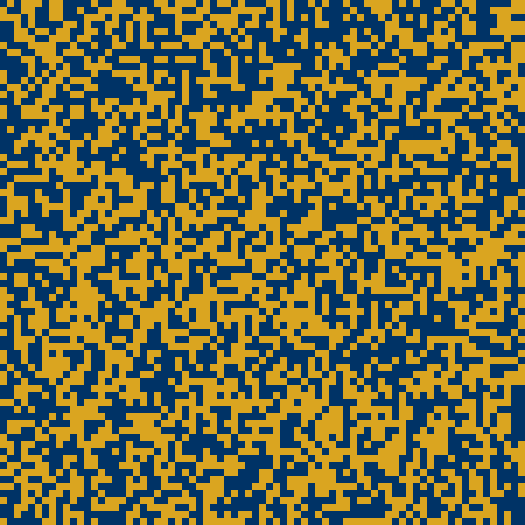

In [12]:
"""
We have a 75 x 75 grid of pixels that we embed in the plane as
a 3.464 x 3.464 unit square (3.464 is about 2sqrt(3)). We use only
two colors here and default again to using wrapping.
"""
c2 = Coloring(75, 75, 3.464, 3.464, 2)
c2.initialize_random()
c2.render()
c2.im

In [13]:
anneal(c2, num_iters=100000, verbose=False)

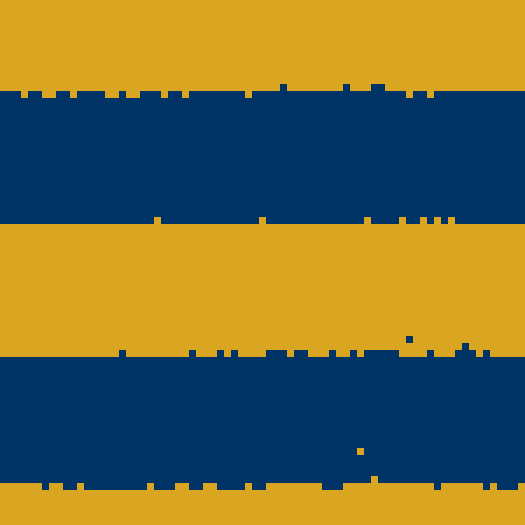

In [14]:
c2.render()
#print(c2.badness())
c2.im

Here we see a slightly different pattern arising: what looks to be wavy stripes running parallel to one another and alternating between red and green. It also seems that the badness of this coloring approaches and hovers around $\frac13$. As it turns out, $\frac13$ is the _best_ we can do with two colors. The first proof of this exact statement (largely since the statement hadn't been considered before this) is given in my [paper](https://arxiv.org/pdf/2008.07987.pdf) with Jacob Stavrianos.

In [385]:
c3 = Coloring(400, 400, 6, 6, 4)

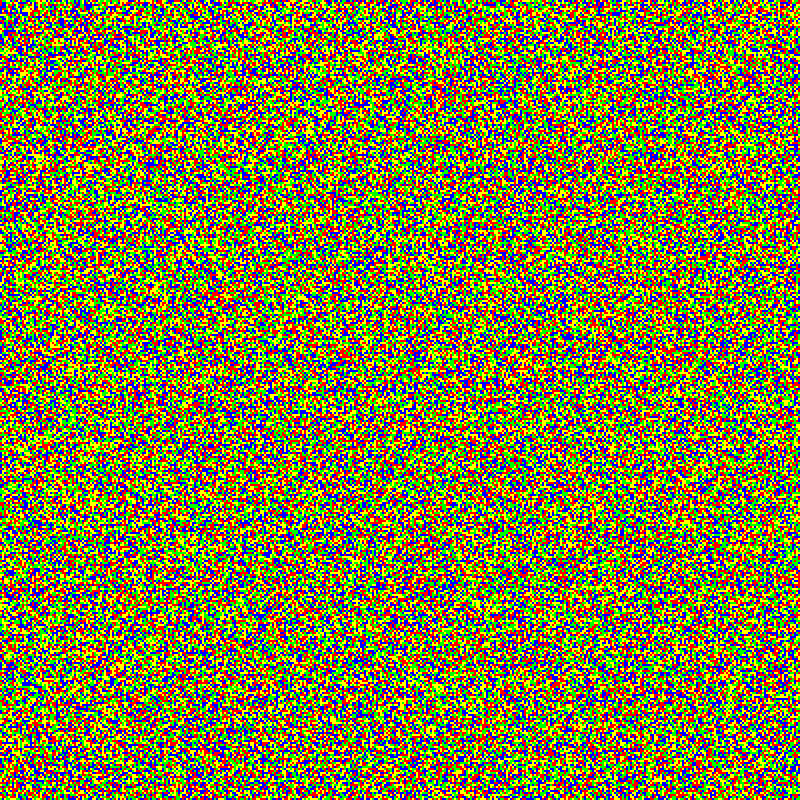

In [387]:
c3.initialize_random()
c3.render()
c3.im

In [399]:
anneal(c3, num_iters=1600000)

0.07105820387190566


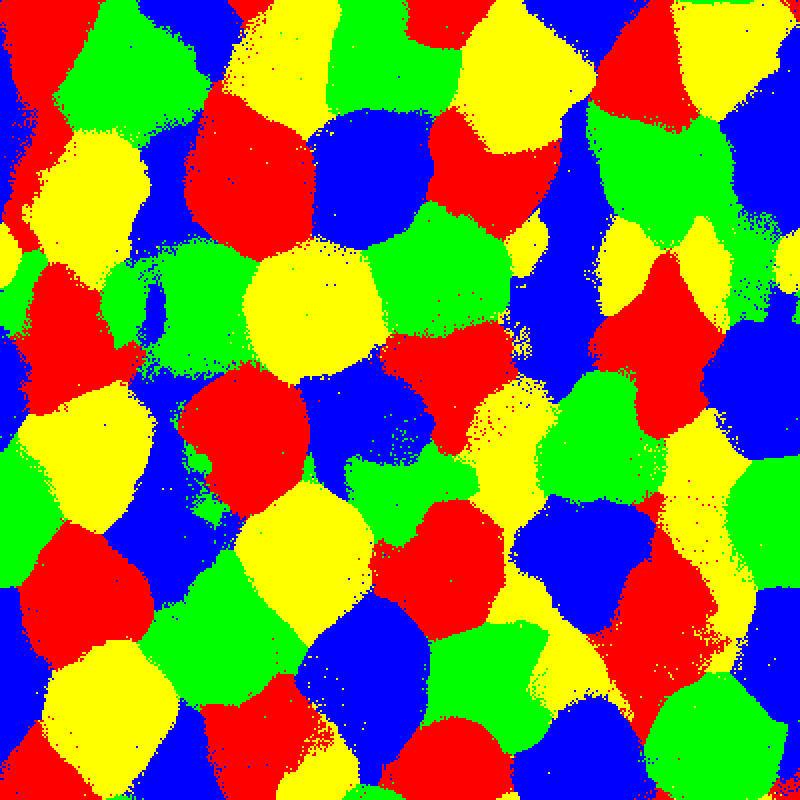

In [401]:
c3.render()
print(c3.badness())
c3.im

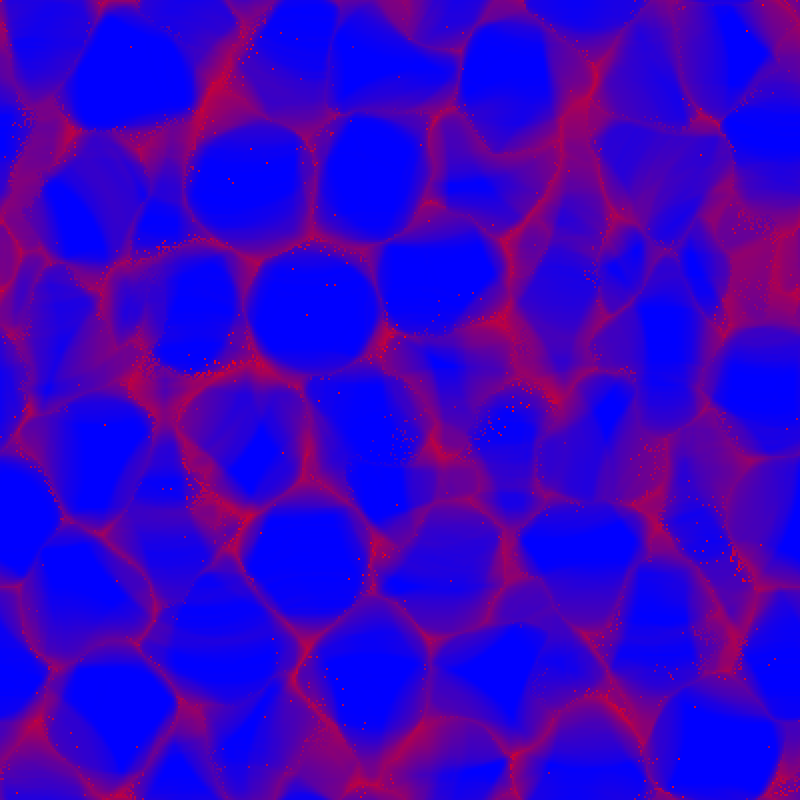

In [402]:
c3.generate_badness_map()